## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [44]:
import os
import keras
import itertools
# Disable GPU
#os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [41]:
import tensorflow as tf

# 自動增長 GPU 記憶體用量
gpu_options = tf.GPUOptions(allow_growth=True)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

# 設定 Keras 使用的 Session
tf.keras.backend.set_session(sess)

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [20]:
from keras.regularizers import l1, l2, l1_l2
from keras.layers import Dropout
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l2_ratio=1e-4,drp_ratio=0.2):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l2(l2_ratio))(input_layer)
            x = Dropout(drp_ratio)(x)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l2(l2_ratio))(x)
            x = Dropout(drp_ratio)(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

def WO_BN_build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l2_ratio=1e-4,drp_ratio=0.2):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l2(l2_ratio))(input_layer)
            x = Dropout(drp_ratio)(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l2(l2_ratio))(x)
            x = Dropout(drp_ratio)(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [47]:
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L2_EXP = [0,1e-2]
Dropout_EXP = [0,0.2]

In [48]:
results = {}
results2 = {}
for regulizer_ratio in L2_EXP:
    for drop in Dropout_EXP:
        keras.backend.clear_session() # 把舊的 Graph 清掉
        
        print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
        print("Experiment with dropout = %.6f" % (drop))
        
        model = build_mlp(input_shape=x_train.shape[1:], l2_ratio=regulizer_ratio,drp_ratio=drop)
        model2 = WO_BN_build_mlp(input_shape=x_train.shape[1:], l2_ratio=regulizer_ratio,drp_ratio=drop)
        
        print("model w BN")
        model.summary()
        print("")
        print("Model w/o BN")
        model2.summary()
        
        optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
        model2.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

        model.fit(x_train, y_train, 
                  epochs=EPOCHS, 
                  batch_size=BATCH_SIZE, 
                  validation_data=(x_test, y_test), 
                  shuffle=True)
        model2.fit(x_train, y_train, 
                  epochs=EPOCHS, 
                  batch_size=BATCH_SIZE, 
                  validation_data=(x_test, y_test), 
                  shuffle=True)
    
        # Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["acc"]
        valid_acc = model.history.history["val_acc"]
        
        train2_loss = model2.history.history["loss"]
        valid2_loss = model2.history.history["val_loss"]
        train2_acc = model2.history.history["acc"]
        valid2_acc = model2.history.history["val_acc"]
    
        exp_name_tag = "BN-l2-%s-DR-%s" %(str(regulizer_ratio),str(drop))
        exp_name_tag2 = "NBN-l2-%s-DR-%s" %(str(regulizer_ratio),str(drop))
        print("--------------------END: "+exp_name_tag+"------------------------------------\n")
        results[exp_name_tag] = {'train-loss': train_loss,
                                 'valid-loss': valid_loss,
                                 'train-acc': train_acc,
                                 'valid-acc': valid_acc}
        results2[exp_name_tag2] = {'train-loss': train2_loss,
                                 'valid-loss': valid2_loss,
                                 'train-acc': train2_acc,
                                 'valid-acc': valid2_acc}

Experiment with Regulizer = 0.000000
Experiment with dropout = 0.000000
model w BN
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
___________________________________________________________

50000/50000 [==============================] - 3s 61us/step - loss: 0.3596 - acc: 0.8888 - val_loss: 2.0881 - val_acc: 0.4809
Epoch 37/50
50000/50000 [==============================] - 3s 63us/step - loss: 0.3389 - acc: 0.8958 - val_loss: 2.0436 - val_acc: 0.4840
Epoch 38/50
50000/50000 [==============================] - 3s 61us/step - loss: 0.3196 - acc: 0.9022 - val_loss: 2.1760 - val_acc: 0.4647
Epoch 39/50
50000/50000 [==============================] - 3s 62us/step - loss: 0.3081 - acc: 0.9057 - val_loss: 2.2189 - val_acc: 0.4707
Epoch 40/50
50000/50000 [==============================] - 3s 62us/step - loss: 0.2901 - acc: 0.9125 - val_loss: 2.2573 - val_acc: 0.4730
Epoch 41/50
50000/50000 [==============================] - 3s 62us/step - loss: 0.2801 - acc: 0.9149 - val_loss: 2.2568 - val_acc: 0.4622
Epoch 42/50
50000/50000 [==============================] - 3s 61us/step - loss: 0.2642 - acc: 0.9217 - val_loss: 2.2106 - val_acc: 0.4731
Epoch 43/50
50000/50000 [=====================

50000/50000 [==============================] - 2s 48us/step - loss: 0.9296 - acc: 0.6734 - val_loss: 1.3434 - val_acc: 0.5392
Epoch 46/50
50000/50000 [==============================] - 2s 49us/step - loss: 0.9189 - acc: 0.6755 - val_loss: 1.5029 - val_acc: 0.5019
Epoch 47/50
50000/50000 [==============================] - 2s 49us/step - loss: 0.9054 - acc: 0.6829 - val_loss: 1.3714 - val_acc: 0.5412
Epoch 48/50
50000/50000 [==============================] - 2s 48us/step - loss: 0.8920 - acc: 0.6875 - val_loss: 1.4033 - val_acc: 0.5257
Epoch 49/50
50000/50000 [==============================] - 2s 49us/step - loss: 0.8799 - acc: 0.6916 - val_loss: 1.4383 - val_acc: 0.5224
Epoch 50/50
50000/50000 [==============================] - 2s 49us/step - loss: 0.8736 - acc: 0.6917 - val_loss: 1.6150 - val_acc: 0.4921
--------------------END: BN-l2-0-DR-0------------------------------------

Experiment with Regulizer = 0.000000
Experiment with dropout = 0.200000
model w BN
__________________________

50000/50000 [==============================] - 3s 63us/step - loss: 1.3719 - acc: 0.5065 - val_loss: 1.4478 - val_acc: 0.4819
Epoch 30/50
50000/50000 [==============================] - 3s 63us/step - loss: 1.3730 - acc: 0.5054 - val_loss: 1.4011 - val_acc: 0.5029
Epoch 31/50
50000/50000 [==============================] - 3s 63us/step - loss: 1.3648 - acc: 0.5101 - val_loss: 1.3712 - val_acc: 0.5090
Epoch 32/50
50000/50000 [==============================] - 3s 64us/step - loss: 1.3648 - acc: 0.5101 - val_loss: 1.3931 - val_acc: 0.5055
Epoch 33/50
50000/50000 [==============================] - 3s 63us/step - loss: 1.3531 - acc: 0.5130 - val_loss: 1.3787 - val_acc: 0.50611s - loss:
Epoch 34/50
50000/50000 [==============================] - 3s 63us/step - loss: 1.3473 - acc: 0.5163 - val_loss: 1.3664 - val_acc: 0.5135
Epoch 35/50
50000/50000 [==============================] - 3s 63us/step - loss: 1.3486 - acc: 0.5137 - val_loss: 1.3861 - val_acc: 0.5055
Epoch 36/50
50000/50000 [===========

50000/50000 [==============================] - 2s 49us/step - loss: 1.3145 - acc: 0.5332 - val_loss: 1.3287 - val_acc: 0.5282
Epoch 39/50
50000/50000 [==============================] - 2s 50us/step - loss: 1.3048 - acc: 0.5332 - val_loss: 1.3404 - val_acc: 0.5292
Epoch 40/50
50000/50000 [==============================] - 2s 50us/step - loss: 1.2987 - acc: 0.5372 - val_loss: 1.3256 - val_acc: 0.5293
Epoch 41/50
50000/50000 [==============================] - 3s 50us/step - loss: 1.2923 - acc: 0.5403 - val_loss: 1.3234 - val_acc: 0.5275
Epoch 42/50
50000/50000 [==============================] - 2s 50us/step - loss: 1.2847 - acc: 0.5416 - val_loss: 1.3218 - val_acc: 0.5252
Epoch 43/50
50000/50000 [==============================] - 2s 50us/step - loss: 1.2769 - acc: 0.5467 - val_loss: 1.3117 - val_acc: 0.5336
Epoch 44/50
50000/50000 [==============================] - 2s 50us/step - loss: 1.2700 - acc: 0.5470 - val_loss: 1.3049 - val_acc: 0.5345
Epoch 45/50
50000/50000 [=====================

50000/50000 [==============================] - 3s 64us/step - loss: 1.7222 - acc: 0.6362 - val_loss: 2.4030 - val_acc: 0.4104
Epoch 23/50
50000/50000 [==============================] - 3s 65us/step - loss: 1.6537 - acc: 0.6366 - val_loss: 2.5212 - val_acc: 0.3676
Epoch 24/50
50000/50000 [==============================] - 3s 64us/step - loss: 1.5881 - acc: 0.6421 - val_loss: 2.4798 - val_acc: 0.3780
Epoch 25/50
50000/50000 [==============================] - 3s 64us/step - loss: 1.5448 - acc: 0.6416 - val_loss: 2.4591 - val_acc: 0.3816
Epoch 26/50
50000/50000 [==============================] - 3s 64us/step - loss: 1.4819 - acc: 0.6482 - val_loss: 2.2368 - val_acc: 0.4122
Epoch 27/50
50000/50000 [==============================] - 3s 64us/step - loss: 1.4319 - acc: 0.6536 - val_loss: 2.0584 - val_acc: 0.4490
Epoch 28/50
50000/50000 [==============================] - 3s 65us/step - loss: 1.3875 - acc: 0.6604 - val_loss: 2.5777 - val_acc: 0.3566
Epoch 29/50
50000/50000 [=====================

Epoch 31/50
50000/50000 [==============================] - 3s 52us/step - loss: 1.7796 - acc: 0.4956 - val_loss: 1.8604 - val_acc: 0.4604
Epoch 32/50
50000/50000 [==============================] - 3s 52us/step - loss: 1.7599 - acc: 0.4932 - val_loss: 1.8004 - val_acc: 0.4728
Epoch 33/50
50000/50000 [==============================] - 3s 52us/step - loss: 1.7400 - acc: 0.4970 - val_loss: 1.8087 - val_acc: 0.45970s - loss: 1.7416 - acc: 0.
Epoch 34/50
50000/50000 [==============================] - 3s 52us/step - loss: 1.7247 - acc: 0.4998 - val_loss: 1.7543 - val_acc: 0.4895
Epoch 35/50
50000/50000 [==============================] - 3s 52us/step - loss: 1.7091 - acc: 0.5030 - val_loss: 1.7378 - val_acc: 0.4940
Epoch 36/50
50000/50000 [==============================] - 3s 52us/step - loss: 1.6989 - acc: 0.5026 - val_loss: 1.7385 - val_acc: 0.4896
Epoch 37/50
50000/50000 [==============================] - 3s 52us/step - loss: 1.6862 - acc: 0.5053 - val_loss: 1.7323 - val_acc: 0.4825
Epoch 3

50000/50000 [==============================] - 3s 66us/step - loss: 3.0621 - acc: 0.4410 - val_loss: 2.9396 - val_acc: 0.4536
Epoch 16/50
50000/50000 [==============================] - 3s 67us/step - loss: 2.8410 - acc: 0.4459 - val_loss: 2.7822 - val_acc: 0.4345
Epoch 17/50
50000/50000 [==============================] - 3s 66us/step - loss: 2.6729 - acc: 0.4425 - val_loss: 2.5582 - val_acc: 0.45742 - ac - ETA: 0s - loss: 2.6799 - acc: 0
Epoch 18/50
50000/50000 [==============================] - 3s 66us/step - loss: 2.4997 - acc: 0.4536 - val_loss: 2.5335 - val_acc: 0.4192
Epoch 19/50
50000/50000 [==============================] - 3s 66us/step - loss: 2.3696 - acc: 0.4535 - val_loss: 2.4630 - val_acc: 0.4119
Epoch 20/50
50000/50000 [==============================] - 3s 65us/step - loss: 2.2501 - acc: 0.4586 - val_loss: 2.1692 - val_acc: 0.4720
Epoch 21/50
50000/50000 [==============================] - 3s 67us/step - loss: 2.1600 - acc: 0.4568 - val_loss: 2.0968 - val_acc: 0.4628
Epoch 

50000/50000 [==============================] - 3s 53us/step - loss: 2.2499 - acc: 0.4310 - val_loss: 2.1756 - val_acc: 0.4527
Epoch 23/50
50000/50000 [==============================] - 3s 53us/step - loss: 2.1786 - acc: 0.4316 - val_loss: 2.1038 - val_acc: 0.4575
Epoch 24/50
50000/50000 [==============================] - 3s 53us/step - loss: 2.1146 - acc: 0.4355 - val_loss: 2.0502 - val_acc: 0.4594
Epoch 25/50
50000/50000 [==============================] - 3s 53us/step - loss: 2.0617 - acc: 0.4355 - val_loss: 2.0026 - val_acc: 0.45781s - loss: 2
Epoch 26/50
50000/50000 [==============================] - 3s 53us/step - loss: 2.0145 - acc: 0.4376 - val_loss: 1.9562 - val_acc: 0.4633
Epoch 27/50
50000/50000 [==============================] - 3s 53us/step - loss: 1.9745 - acc: 0.4382 - val_loss: 1.9201 - val_acc: 0.4630
Epoch 28/50
50000/50000 [==============================] - 3s 53us/step - loss: 1.9377 - acc: 0.4423 - val_loss: 1.8898 - val_acc: 0.4603A:
Epoch 29/50
50000/50000 [=======

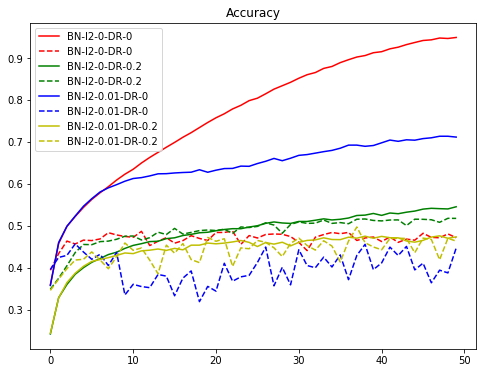

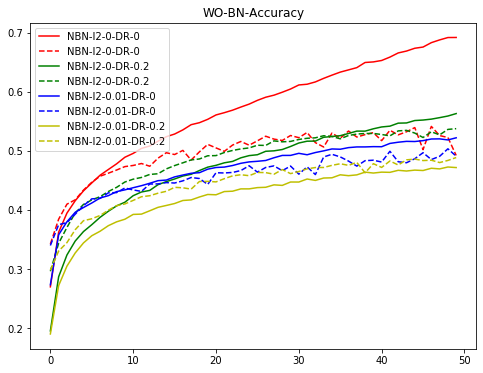

In [49]:
import matplotlib.pyplot as plt
%matplotlib inline

color_bar = ["r", "g", "b", "y", "m", "k"]

'''
plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()
'''
plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='upper left')
plt.show()
'''
plt.figure(figsize=(8,6))
for i, cond in enumerate(results2.keys()):
    plt.plot(range(len(results2[cond]['train-loss'])),results2[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results2[cond]['valid-loss'])),results2[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("WO-BN-Loss")
plt.legend()
plt.show()
'''
plt.figure(figsize=(8,6))
for i, cond in enumerate(results2.keys()):
    plt.plot(range(len(results2[cond]['train-acc'])),results2[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results2[cond]['valid-acc'])),results2[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("WO-BN-Accuracy")
plt.legend(loc='upper left')
plt.show()